# **Project 4:   Charlotte's Neighborhood Crime Through Clustering Analysis**

##  **Introduction**
Crime is a concern for many urban areas in the United States, and Charlotte is no exception. It is important to understand crime patterns and statistics to help communities and law enforcement agencies develop plans, allocate resources, and engage with the community to improve public safety. The Charlotte-Mecklenburg Police Department (CMPD) regularly publishes detailed crime reports. As of July 22, 2024, overall crime in Charlotte has seen a slight increase of 1% compared to the previous year. This includes various types of crimes, categorized broadly into violent crimes and property crimes.
Previously, [Project 1 ](https://pmb-7684.github.io/Data_Mining_Project_1/) Charlotte's Neighborhood Crime Over Time explored the data through exploratory data analysis. It focused on how much crime changed over time based on the different neighborhoods or divisions.

For this project, the data will be explored through clustering analysis. Again, the data explored how crime has evolved over time in different communities and how does location (such as open field, department store, hotel/motel, etc.) of the incident within neighborhoods effective crime. The difference is that clustering will be used to explore if certain neighborhood belongs to the same cluster and types of crimes are likely to happen in those clusters.

By determining communities that are experiencing higher than normal levels of crime and specific location, the city, local law enforcement, and community can help allocated resources, develop plans and support community outreach to support all neighborhoods.

CMPD Data [Portal](https://data.charlottenc.gov/datasets/charlotte::cmpd-incidents-1/about)

City of Charlotte[ GIS](https://maps.mecknc.gov/openmapping/data.html)

The full jupyter notebook can be found [here:](https://colab.research.google.com/drive/1pQnLC2ZXssp-9LBDGq8JUEc-SZblqFLt?usp=sharing)




## **What is clustering and how does it work?**

`Explain what clustering is and how it works (e.g., k-means and/or agglomerative that we have gone over in class).`

In general, clustering is the process of grouping items with common characteristics into a group.

K-means is an unsupervised algorithm used for clustering. The algorithm works by dividing a group of observations into a predetermined number of clusters. This number of clusters (k) is determined by the user. The user can either randomly select a number or use a method such as "elbow method" to calculate the number of clusters. Then k data are randomly selected to be centroid(center of the cluster). Each observation is assigned to a centroid based on distance to the closest centroid. Once all observations are assigned, recalculate the centroid by taking the average of the points assignment to the cluster. then determine the distance and reassign each observation. The algorithm is repeated until the centroids no longer move, no data points change clusters, or the maximum number of iterations is reached.

Agglomerative Clustering is another clustering algorithm.  It works by splitting and merging the closest pairs of clusters until all the observations belong to a single cluster.

##  **Dataset**
The dataset is available from the city of Charlotte's open data portal. It is available in various formats including CSV and contains both criminal and non-criminal incident reports from 2017 through 2024. At the time this file was downloaded, it contained 688,973 observations and 29 features.


###Some Domain and Variable Notes:
-	`X`, `Y` are unknown decimal values.

-	`INCIDENT_REPORT_ID` is the case number associated with the incident.

-	`LOCATION` is the physical address of the incident.

-	`X_COORD_PUBLIC`, `Y_COORD_PUBLIC` are unknown integer values.

-	`CMPD_PATROL_DIVISION` is the name of the division. It corresponds to numeric 'DIVISION_ID'.

-	`ADDRESS_DESCRIPTION` is a higher-level description of where the incident took place. Field mainly contained 'Location of occurrence' or 'Location where officer took report'

- `NPA` is the Neighborhood Profile Area ID, a unique number that is assigned to different neighborhoods in Charlotte. It replaced the previous method of using the name of the community.

-	`PLACE_TYPE_DESCRIPTION` is a detailed description of 'LOCATION_TYPE_DESCRIPTION' which indicates if private resident, Gas station, etc.

-	`CLEARANCE_DETAIL_STATUS` is detailed description of 'CLEARANCE_STATUS' which provides how a case was cleared.

- `HIGHEST_NIBRS_CODE` is the highest offense id number for the incident as defined by the FBI's National Incident-Based Reporting System (NIBRS)

-	`OBJECTID` is the index.

- `GlobalID` is an unknown alpha-numeric value.


The shape of the orginal dataset is (688973, 29).

##  **Pre-Processing**

By thoroughly cleaning the data, we will improve the accuracy of our model and save time by removing errors in advance.  The same pre-processing was completed on this project as completed on project one. Since most of the pre-processing was completed for project 1, below is a summary of task completed.  The following features were not used in the modeling or analysis and removed.

##### **Irrelevant**

`X` and `X_COORD_PUBLIC` contained the same value. The only difference was `X` was in decimal format and  `X_COORD_PUBLIC` was in integer format.  This was the same situation for '`Y` and `Y_COORD_PUBLIC`.

`INCIDENT_REPORT_ID` represents the unique report number associated with each incident.

`GlobalID` is an alphanumeric variable. Its purpose could not be determined.

`OBJECTID` seems to be an index for the dataset.

`LOCATION` (physical address of the incident), `CITY`, `STATE`, and `ZIP` can be replaced by the DIVISION_ID OR CMPD_PATROL-DIVISION which are better suited in describing where the incident took place.

##### **Missing Values**

After checking for missing data, there were six columns that were missing values: STATE, ZIP, CMPD_PATROL-DIVISION, DATE_INCIDENT_END, ADDRESS_DESCRIPTION, and CLEARANCE DATE.  STATE and ZIP as stated above were not used and removed.

`CMPD_PATROL_DIVISION` is a more descriptive version of DIVISION_ID, so we can impute the missing information based on the current values in DIVISION_ID.  

`DATE_INCIDENT_END` indicates the date that the incident or cases were resolved.  I will impute those missing dates with today’s current date.  This will provide an accurate measure of the number of days that a case has been open, if I decide to create a column in the future.  For the same reason we will retain the CLEARANCE DATE and impute it with the current date.

`ADDRESS_DESCRIPTION` can also be replaced by the CMPD_PATROL-DIVISION.

`LOCATION_TYPE_DESCRIPTION` provides a high-level location for the incident. This will be replaced with a better feature.

#####**Data Types Checked**

All variables were of type `object`, except for YEAR, X_COORD_PUBLIC, Y_COORD_PUBLIC, LATITUDE_PUBLIC, LATITUDE_PUBLIC, and NPA.  Those data types are numeric.

##### **Index**
Normally, when data is imported, python automatically creates an index; however, the first row is index as 0 rather than 1. Now, the first row is indexed at 1 and the column is named ID. Since we are analyzing clusters, we do not need the ID feature.

The data set contains 14 features and 688,345 observations.  

Now that we have a clean file, the data set needs to be transformed.  The cluster analysis will be based on the sixteen divisions and the type of crimes in those divisions.  So, the number of features will be considerably smaller.
The code and output are below.

`CLT_pivot = pd.pivot_table(CLT_group, values='Count',
                          index='CMPD_PATROL_DIVISION',
                          columns='HIGHEST_NIBRS_DESCRIPTION', aggfunc='sum', fill_value=0)`



In [ ]:
# Setup workspace

# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# For GIS
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
from shapely.geometry import Point, Polygon

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (13, 7)

In [ ]:
# import data set
data_file = '/content/sample_data/CMPD_Incidents.csv';

CLT_crime = pd.read_csv(data_file, on_bad_lines = 'skip')
pd.set_option('display.max_columns', None)

<ipython-input-2-616546df4923>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  CLT_crime = pd.read_csv(data_file, on_bad_lines = 'skip')


In [ ]:
CLT_crime2 = CLT_crime.copy()

In [ ]:
CLT_crime = CLT_crime2
CLT_crime.head(6)

X              Y  YEAR INCIDENT_REPORT_ID  \
0  1.405570e+06  573263.999990  2017   20170713-1513-05   
1  1.454066e+06  544138.999841  2022   20220503-0227-00   
2  1.476909e+06  568895.999868  2019   20190822-2020-01   
3  1.449971e+06  543008.000135  2023   20230508-0709-02   
4  1.431411e+06  538409.000146  2018   20180110-1702-01   
5  1.472209e+06  569663.999972  2020   20200204-2009-02   

                LOCATION       CITY STATE    ZIP  X_COORD_PUBLIC  \
0  10500 TURKEY POINT DR  CHARLOTTE    NC  28214         1405570   
1     1000 N CALDWELL ST  CHARLOTTE    NC  28205         1454066   
2    100 E MCCULLOUGH DR  CHARLOTTE    NC  28262         1476909   
3           100 W 5TH ST  CHARLOTTE    NC  28202         1449971   
4       2600 HEMPHILL ST  CHARLOTTE    NC  28208         1431411   
5            7600 IBM DR  CHARLOTTE    NC  28262         1472209   

   Y_COORD_PUBLIC  LATITUDE_PUBLIC  LONGITUDE_PUBLIC DIVISION_ID  \
0          573264        35.308755        -80.992632          11   
1          544139        35.231309        -80.828305          06   
2          568896        35.300454        -80.753286          14   
3          543008        35.227994        -80.841946          01   
4          538409        35.214398        -80.903790          26   
5          569664        35.302335        -80.769082          14   

  CMPD_PATROL_DIVISION  NPA           DATE_REPORTED     DATE_INCIDENT_BEGAN  \
0                North  156  2017/07/13 00:00:00+00  2016/09/16 00:00:00+00   
1              Eastway   22  2022/05/03 00:00:00+00  2022/05/03 00:00:00+00   
2      University City  219  2019/08/22 00:00:00+00  2019/08/22 00:00:00+00   
3              Central  476  2023/05/08 00:00:00+00  2023/05/06 00:00:00+00   
4             Westover  120  2018/01/10 00:00:00+00  2018/01/09 00:00:00+00   
5      University City  331  2020/02/04 00:00:00+00  2020/02/04 00:00:00+00   

        DATE_INCIDENT_END     ADDRESS_DESCRIPTION LOCATION_TYPE_DESCRIPTION  \
0  2017/07/13 00:00:00+00  Location of occurrence                     Other   
1                     NaN  Location of occurrence                  Outdoors   
2  2019/08/22 00:00:00+00  Location of occurrence               Parking Lot   
3  2023/05/06 00:00:00+00  Location of occurrence                   Indoors   
4  2018/01/10 00:00:00+00  Location of occurrence                  Outdoors   
5  2020/02/04 00:00:00+00  Location of occurrence               Parking Lot   

   PLACE_TYPE_DESCRIPTION       PLACE_DETAIL_DESCRIPTION   CLEARANCE_STATUS  \
0             Residential              Private Residence               Open   
1               Open Area                     Open Field  Cleared by Arrest   
2        Commercial Place                    Hotel/Motel  Cleared by Arrest   
3        Commercial Place           Bar/Tavern/Nightclub               Open   
4             Residential              Private Residence               Open   
5  Public/Non-Residential  School - Primary or Secondary               Open   

  CLEARANCE_DETAIL_STATUS          CLEARANCE_DATE HIGHEST_NIBRS_CODE  \
0                    Open                     NaN                13C   
1       Cleared by Arrest  2022/05/03 00:00:00+00                35A   
2       Cleared by Arrest  2019/08/22 00:00:00+00                280   
3                    Open                     NaN                23H   
4                    Open                     NaN                220   
5                    Open                     NaN                23F   

  HIGHEST_NIBRS_DESCRIPTION  OBJECTID                                GlobalID  
0              Intimidation         1  {EFBEB3D4-024E-4E5A-B0D2-E449A913F081}  
1  Drug/Narcotic Violations         2  {8DD3EEF4-7FAA-40A1-BDA4-E7C4B276BF03}  
2  Stolen Property Offenses         3  {163A308E-1CB0-4CFB-9406-D656232B7114}  
3          All Other Thefts         4  {5D88C5F8-CBEF-44C6-8F40-D24C0B212E29}  
4              Burglary/B&E         5  {82AFCFBD-272E-4161-B538-F91803C54C3B}  

In [ ]:
CLT_crime.shape

(688973, 29)

In [ ]:
CLT_crime.isna().sum()

X                                 0
Y                                 0
YEAR                              0
INCIDENT_REPORT_ID                0
LOCATION                          0
CITY                              0
STATE                             5
ZIP                          222686
X_COORD_PUBLIC                    0
Y_COORD_PUBLIC                    0
LATITUDE_PUBLIC                   0
LONGITUDE_PUBLIC                  0
DIVISION_ID                       0
CMPD_PATROL_DIVISION            627
NPA                               0
DATE_REPORTED                     0
DATE_INCIDENT_BEGAN               0
DATE_INCIDENT_END            168694
ADDRESS_DESCRIPTION               3
LOCATION_TYPE_DESCRIPTION         0
PLACE_TYPE_DESCRIPTION            0
PLACE_DETAIL_DESCRIPTION          0
CLEARANCE_STATUS                  0
CLEARANCE_DETAIL_STATUS           0
CLEARANCE_DATE               411157
HIGHEST_NIBRS_CODE                0
HIGHEST_NIBRS_DESCRIPTION         0
OBJECTID                          0
GlobalID                          0
dtype: int64

In [ ]:
# drop columns
CLT_crime = CLT_crime.drop(['X','Y','X_COORD_PUBLIC', 'Y_COORD_PUBLIC','INCIDENT_REPORT_ID','LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC',
                            'OBJECTID','GlobalID', 'ZIP', 'CITY', 'STATE', 'ADDRESS_DESCRIPTION','LOCATION', 'LOCATION_TYPE_DESCRIPTION'], axis=1)


In [ ]:
# unique division names
CLT_crime['CMPD_PATROL_DIVISION'].unique()

array(['North', 'Eastway', 'University City', 'Central', 'Westover',
       'North Tryon', 'South', 'Airport', 'Providence', 'Independence',
       'Steele Creek', 'Hickory Grove', 'Freedom', 'Metro', nan,
       'Huntersville', 'Davidson', 'Unknown'], dtype=object)

In [ ]:
division_mapping = {
   '11': 'North',
   '06': 'Eastway',
   '14': 'University City',
   '01': 'Central',
   '26': 'Westover',
   '07': 'North Tryon',
   '22': 'South',
   '28': 'Airport',
   '16': 'Providence',
   '17': 'Independence',
   '21': 'Steele Creek',
   '12': 'Hickory Grove',
   '27': 'Freedom',
   '02': 'Metro',
   '92': 'Huntersville',
   '90': 'Davidson'
}



In [ ]:
# fillna to address missing values in CMPD_PATROL_DIVISION
CLT_crime['CMPD_PATROL_DIVISION'] = CLT_crime['CMPD_PATROL_DIVISION'].fillna(CLT_crime['DIVISION_ID'].map(division_mapping))

In [ ]:
CLT_crime['CMPD_PATROL_DIVISION'].isna().sum()

627

In [ ]:
# drop rows with Na in the CMPD_PATROL_DIVISION column
CLT_crime = CLT_crime.dropna(subset=['CMPD_PATROL_DIVISION'])

#drop Unknown
CLT_crime.drop(CLT_crime[CLT_crime['CMPD_PATROL_DIVISION']=='Unknown'].index, inplace = True)

In [ ]:
# impute replace values with current date
from datetime import datetime

current_date = datetime.now().date()

CLT_crime['CLEARANCE_DATE'].fillna(current_date, inplace=True)
CLT_crime['DATE_INCIDENT_END'].fillna(current_date, inplace=True)

<ipython-input-13-068dbe122c22>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CLT_crime['CLEARANCE_DATE'].fillna(current_date, inplace=True)
<ipython-input-13-068dbe122c22>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [ ]:
CLT_crime.index = [x for x in range(1, len(CLT_crime.values)+1)]

# add index field name
CLT_crime.index.name = 'id'
CLT_crime.head(4)

YEAR DIVISION_ID CMPD_PATROL_DIVISION  NPA           DATE_REPORTED  \
id                                                                       
1   2017          11                North  156  2017/07/13 00:00:00+00   
2   2022          06              Eastway   22  2022/05/03 00:00:00+00   
3   2019          14      University City  219  2019/08/22 00:00:00+00   
4   2023          01              Central  476  2023/05/08 00:00:00+00   

       DATE_INCIDENT_BEGAN       DATE_INCIDENT_END PLACE_TYPE_DESCRIPTION  \
id                                                                          
1   2016/09/16 00:00:00+00  2017/07/13 00:00:00+00            Residential   
2   2022/05/03 00:00:00+00              2024-11-16              Open Area   
3   2019/08/22 00:00:00+00  2019/08/22 00:00:00+00       Commercial Place   
4   2023/05/06 00:00:00+00  2023/05/06 00:00:00+00       Commercial Place   

   PLACE_DETAIL_DESCRIPTION   CLEARANCE_STATUS CLEARANCE_DETAIL_STATUS  \
id                                                                       
1         Private Residence               Open                    Open   
2                Open Field  Cleared by Arrest       Cleared by Arrest   
3               Hotel/Motel  Cleared by Arrest       Cleared by Arrest   
4      Bar/Tavern/Nightclub               Open                    Open   

            CLEARANCE_DATE HIGHEST_NIBRS_CODE HIGHEST_NIBRS_DESCRIPTION  
id                                                                       
1               2024-11-16                13C              Intimidation  
2   2022/05/03 00:00:00+00                35A  Drug/Narcotic Violations  
3   2019/08/22 00:00:00+00                280  Stolen Property Offenses  
4               2024-11-16                23H          All Other Thefts

In [ ]:
CLT_crime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688345 entries, 1 to 688345
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   YEAR                       688345 non-null  int64 
 1   DIVISION_ID                688345 non-null  object
 2   CMPD_PATROL_DIVISION       688345 non-null  object
 3   NPA                        688345 non-null  int64 
 4   DATE_REPORTED              688345 non-null  object
 5   DATE_INCIDENT_BEGAN        688345 non-null  object
 6   DATE_INCIDENT_END          688345 non-null  object
 7   PLACE_TYPE_DESCRIPTION     688345 non-null  object
 8   PLACE_DETAIL_DESCRIPTION   688345 non-null  object
 9   CLEARANCE_STATUS           688345 non-null  object
 10  CLEARANCE_DETAIL_STATUS    688345 non-null  object
 11  CLEARANCE_DATE             688345 non-null  object
 12  HIGHEST_NIBRS_CODE         688345 non-null  object
 13  HIGHEST_NIBRS_DESCRIPTION  688345 non-null  objec

In [ ]:
CLT_crime.isna().sum()

YEAR                         0
DIVISION_ID                  0
CMPD_PATROL_DIVISION         0
NPA                          0
DATE_REPORTED                0
DATE_INCIDENT_BEGAN          0
DATE_INCIDENT_END            0
PLACE_TYPE_DESCRIPTION       0
PLACE_DETAIL_DESCRIPTION     0
CLEARANCE_STATUS             0
CLEARANCE_DETAIL_STATUS      0
CLEARANCE_DATE               0
HIGHEST_NIBRS_CODE           0
HIGHEST_NIBRS_DESCRIPTION    0
dtype: int64

In [ ]:
CLT_crime.shape

(688345, 14)

In [ ]:
CLT_crime['Month'] = CLT_crime['DATE_INCIDENT_BEGAN'].str.split("/", expand = True)[1]

In [ ]:
dict_month = {"Month":{"01":"January", "02":"February", "03":"March", "04":"April",
                       "05":"May", "06":"June","07": "July", "08":"August", "09":"September",
                       "10":"October", "11":"November", "12":"December"}}

In [ ]:
CLT_crime.replace(dict_month, inplace=True)
CLT_crime.head(10)

YEAR DIVISION_ID CMPD_PATROL_DIVISION  NPA           DATE_REPORTED  \
id                                                                       
1   2017          11                North  156  2017/07/13 00:00:00+00   
2   2022          06              Eastway   22  2022/05/03 00:00:00+00   
3   2019          14      University City  219  2019/08/22 00:00:00+00   
4   2023          01              Central  476  2023/05/08 00:00:00+00   
5   2018          26             Westover  120  2018/01/10 00:00:00+00   
6   2020          14      University City  331  2020/02/04 00:00:00+00   
7   2022          07          North Tryon   21  2022/04/21 00:00:00+00   
8   2019          22                South  302  2019/07/31 00:00:00+00   
9   2021          01              Central  476  2021/12/05 00:00:00+00   
10  2021          06              Eastway  378  2021/05/14 00:00:00+00   

       DATE_INCIDENT_BEGAN       DATE_INCIDENT_END  PLACE_TYPE_DESCRIPTION  \
id                                                                           
1   2016/09/16 00:00:00+00  2017/07/13 00:00:00+00             Residential   
2   2022/05/03 00:00:00+00              2024-11-16               Open Area   
3   2019/08/22 00:00:00+00  2019/08/22 00:00:00+00        Commercial Place   
4   2023/05/06 00:00:00+00  2023/05/06 00:00:00+00        Commercial Place   
5   2018/01/09 00:00:00+00  2018/01/10 00:00:00+00             Residential   
6   2020/02/04 00:00:00+00  2020/02/04 00:00:00+00  Public/Non-Residential   
7   2022/04/19 00:00:00+00  2022/04/19 00:00:00+00  Public/Non-Residential   
8   2019/07/31 00:00:00+00              2024-11-16             Residential   
9   2021/12/05 00:00:00+00  2021/12/05 00:00:00+00        Commercial Place   
10  2021/05/14 00:00:00+00              2024-11-16             Residential   

          PLACE_DETAIL_DESCRIPTION   CLEARANCE_STATUS CLEARANCE_DETAIL_STATUS  \
id                                                                              
1                Private Residence               Open                    Open   
2                       Open Field  Cleared by Arrest       Cleared by Arrest   
3                      Hotel/Motel  Cleared by Arrest       Cleared by Arrest   
4             Bar/Tavern/Nightclub               Open                    Open   
5                Private Residence               Open                    Open   
6    School - Primary or Secondary               Open                    Open   
7   Other - Public/Non-Residential               Open                    Open   
8     Apartment/Duplex Private Res               Open                    Open   
9         Other - Commercial Place               Open                    Open   
10               Private Residence               Open                    Open   

            CLEARANCE_DATE HIGHEST_NIBRS_CODE    HIGHEST_NIBRS_DESCRIPTION  \
id                                                                           
1               2024-11-16                13C                 Intimidation   
2   2022/05/03 00:00:00+00                35A     Drug/Narcotic Violations   
3   2019/08/22 00:00:00+00                280     Stolen Property Offenses   
4               2024-11-16                23H             All Other Thefts   
5               2024-11-16                220                 Burglary/B&E   
6               2024-11-16                23F     Theft From Motor Vehicle   
7               2024-11-16                90Z           All Other Offenses   
8               2024-11-16                899  Other Unlisted Non-Criminal   
9               2024-11-16                23F     Theft From Motor Vehicle   
10              2024-11-16                23H             All Other Thefts   

        Month  
id             
1   September  
2         May  
3      August  
4         May  
5     January  
6    February  
7       April  
8        July  
9    December  
10        May

##### Transformation#####

In [ ]:
#Transformation using pivot table

CLT_crime['Count'] = 1  #create a temp column to count occurrences
CLT_group = CLT_crime.groupby(['CMPD_PATROL_DIVISION','YEAR', 'HIGHEST_NIBRS_DESCRIPTION']).size().reset_index(name='Count')

years = CLT_group['YEAR'].nunique()


In [ ]:
CLT_pivot = pd.pivot_table(CLT_group, values='Count',
                          index='CMPD_PATROL_DIVISION',
                          columns='HIGHEST_NIBRS_DESCRIPTION', aggfunc='sum', fill_value=0)

In [ ]:
CLT_pivot

HIGHEST_NIBRS_DESCRIPTION  Affray  Aggravated Assault  All Other Offenses  \
CMPD_PATROL_DIVISION                                                        
Airport                        12                  21                1132   
Central                       128                 921                4080   
Davidson                        0                   0                   0   
Eastway                       138                1319                5326   
Freedom                       218                2109                4577   
Hickory Grove                  90                1287                4271   
Huntersville                    0                  10                  56   
Independence                   99                1160                4398   
Metro                         212                2838                4735   
North                         101                2272                5753   
North Tryon                    89                2271                5686   
Providence                    109                 704                3972   
South                          27                 438                3270   
Steele Creek                  123                2138                6667   
University City               150                2027                9040   
Westover                       95                1825                4272   

HIGHEST_NIBRS_DESCRIPTION  All Other Thefts  Animal Cruelty  Arson  \
CMPD_PATROL_DIVISION                                                 
Airport                                1877               2      2   
Central                                5785              13     56   
Davidson                                  0               0      0   
Eastway                                3492              11     59   
Freedom                                4126              37    124   
Hickory Grove                          3013              13     84   
Huntersville                             26               0      2   
Independence                           2791              18     53   
Metro                                  4158              44    132   
North                                  5165              58     96   
North Tryon                            3416              28     91   
Providence                             4317              11     33   
South                                  3883              12     35   
Steele Creek                           6042              30     73   
University City                        6449              41     80   
Westover                               4545              17    103   

HIGHEST_NIBRS_DESCRIPTION  Assisting Gambling  Assisting Prostitution  \
CMPD_PATROL_DIVISION                                                    
Airport                                     0                       0   
Central                                     0                       0   
Davidson                                    0                       0   
Eastway                                     0                       0   
Freedom                                     2                       0   
Hickory Grove                               1                       0   
Huntersville                                0                       0   
Independence                                1                       1   
Metro                                       0                       0   
North                                       0                       1   
North Tryon                                 2                       1   
Providence                                  0                       1   
South                                       0                       1   
Steele Creek                                1                       1   
University City                             2                       2   
Westover                                    1                       1   

HIGHEST_NIBRS_DESCRIPTION  Betting/Wa

In [ ]:
# Convert to HTML
html_table = CLT_pivot.to_html()

#save ti=o file
with open("CLT_pivot_table.html", "w") as file:
    file.write(html_table)


In [ ]:
print(CLT_pivot.to_markdown())

| CMPD_PATROL_DIVISION   |   Affray |   Aggravated Assault |   All Other Offenses |   All Other Thefts |   Animal Cruelty |   Arson |   Assisting Gambling |   Assisting Prostitution |   Betting/Wagering |   Bribery |   Burglary/B&E |   Counterfeiting/Forgery |   Credit Card/Teller Fraud |   Curfew/Loitering/Vagrancy Violations |   Damage/Vandalism Of Property |   Disorderly Conduct |   Dog Bite/Animal Control Incident |   Driving Under The Influence |   Drug Equipment Violations |   Drug/Narcotic Violations |   Embezzlement |   Extortion/Blackmail |   False Pretenses/Swindle |   Family Offenses; Nonviolent |   Fire (Accidental/Non-Arson) |   Forcible Fondling |   Forcible Rape |   Forcible Sodomy |   Gambling Equipment Violations |   Gas Leak |   Hacking/Computer Invasion |   Human Trafficking, Commercial Sex Acts |   Human Trafficking, Involuntary Servitude |   Identity Theft |   Impersonation |   Incest |   Indecent Exposure |   Intimidation |   Justifiable Homicide |   Kidnapping | 

Next, we need to "normalize"  the data in a non-statistical way.  Below, there are a lot of variances between the data points.   To achieve this let's divide the total crime count by the number of years of crime data available.  Normalization is beneficial for clustering models like k-means.  This model uses distance between points and extreme values can dominate the results.

Lastly, the data needs to be standardized.  This is a requirement for both k-means and agglomerative hierarchical clustering.  It transforms the data to having a mean of 0 and standard deviation of 1.


In [ ]:
# normalize data
'''
response from co-pilot (need to verify; it makes sense; make sure it's not making things up)
Normalizing the Data by Year
Normalizing by year means adjusting the crime counts to make them comparable across different years.
This is particularly useful if the number of crimes reported varies significantly from year to year.

In your case, normalization can be done by dividing the total crime count by the number of years you
have data for. This way, each entry in the DataFrame represents the average number of crimes per year
for that crime type in the neighborhood.
'''

CLT_pivot_normalized = CLT_pivot / years
CLT_pivot_normalized

HIGHEST_NIBRS_DESCRIPTION  Affray  Aggravated Assault  All Other Offenses  \
CMPD_PATROL_DIVISION                                                        
Airport                     1.500               2.625             141.500   
Central                    16.000             115.125             510.000   
Davidson                    0.000               0.000               0.000   
Eastway                    17.250             164.875             665.750   
Freedom                    27.250             263.625             572.125   
Hickory Grove              11.250             160.875             533.875   
Huntersville                0.000               1.250               7.000   
Independence               12.375             145.000             549.750   
Metro                      26.500             354.750             591.875   
North                      12.625             284.000             719.125   
North Tryon                11.125             283.875             710.750   
Providence                 13.625              88.000             496.500   
South                       3.375              54.750             408.750   
Steele Creek               15.375             267.250             833.375   
University City            18.750             253.375            1130.000   
Westover                   11.875             228.125             534.000   

HIGHEST_NIBRS_DESCRIPTION  All Other Thefts  Animal Cruelty   Arson  \
CMPD_PATROL_DIVISION                                                  
Airport                             234.625           0.250   0.250   
Central                             723.125           1.625   7.000   
Davidson                              0.000           0.000   0.000   
Eastway                             436.500           1.375   7.375   
Freedom                             515.750           4.625  15.500   
Hickory Grove                       376.625           1.625  10.500   
Huntersville                          3.250           0.000   0.250   
Independence                        348.875           2.250   6.625   
Metro                               519.750           5.500  16.500   
North                               645.625           7.250  12.000   
North Tryon                         427.000           3.500  11.375   
Providence                          539.625           1.375   4.125   
South                               485.375           1.500   4.375   
Steele Creek                        755.250           3.750   9.125   
University City                     806.125           5.125  10.000   
Westover                            568.125           2.125  12.875   

HIGHEST_NIBRS_DESCRIPTION  Assisting Gambling  Assisting Prostitution  \
CMPD_PATROL_DIVISION                                                    
Airport                                 0.000                   0.000   
Central                                 0.000                   0.000   
Davidson                                0.000                   0.000   
Eastway                                 0.000                   0.000   
Freedom                                 0.250                   0.000   
Hickory Grove                           0.125                   0.000   
Huntersville                            0.000                   0.000   
Independence                            0.125                   0.125   
Metro                                   0.000                   0.000   
North                                   0.000                   0.125   
North Tryon                             0.250                   0.125   
Providence                              0.000                   0.125   
South                                   0.000                   0.125   
Steele Creek                            0.125                   0.125   
University City                         0.250                   0.250   
Westover                                0.125                   0.125   

HIGHEST_NIBRS_DESCR

In [ ]:
CLT_pivot_normalized.shape

(16, 72)

#####Standardization#####



In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

CLT_standard_norm = pd.DataFrame(StandardScaler().fit_transform(CLT_pivot_normalized ),columns = CLT_pivot_normalized .columns)
CLT_standard_norm2 = CLT_standard_norm.copy()
CLT_standard_norm

HIGHEST_NIBRS_DESCRIPTION    Affray  Aggravated Assault  All Other Offenses  \
0                         -1.370547           -1.476510           -1.364242   
1                          0.447706           -0.464239           -0.054294   
2                         -1.558643           -1.500129           -1.867248   
3                          0.604452           -0.016590            0.499368   
4                          1.858419            0.871959            0.166548   
5                         -0.147929           -0.052582            0.030577   
6                         -1.558643           -1.488882           -1.842364   
7                         -0.006858           -0.195425            0.087010   
8                          1.764372            1.691899            0.236756   
9                          0.024492            1.055293            0.689106   
10                        -0.163604            1.054168            0.659334   
11                         0.149888           -0.708309           -0.102284   
12                        -1.135428           -1.007491           -0.414219   
13                         0.369333            0.904577            1.095243   
14                         0.792547            0.779730            2.149689   
15                        -0.069556            0.552531            0.031021   

HIGHEST_NIBRS_DESCRIPTION  All Other Thefts  Animal Cruelty     Arson  \
0                                 -0.997799       -1.147077 -1.535567   
1                                  1.149668       -0.480788 -0.196788   
2                                 -2.029221       -1.268221 -1.585151   
3                                 -0.110348       -0.601932 -0.122411   
4                                  0.238039        0.972934  1.489082   
5                                 -0.373561       -0.480788  0.497394   
6                                 -2.014934       -1.268221 -1.535567   
7                                 -0.495551       -0.177929 -0.271165   
8                                  0.255623        1.396936  1.687419   
9                                  0.808975        2.244940  0.794900   
10                                -0.152110        0.427788  0.670939   
11                                 0.342994       -0.601932 -0.767009   
12                                 0.104509       -0.541360 -0.717424   
13                                 1.290891        0.548931  0.224679   
14                                 1.514540        1.215221  0.398225   
15                                 0.468282       -0.238501  0.968445   

HIGHEST_NIBRS_DESCRIPTION  Assisting Gambling  Assisting Prostitution  \
0                                   -0.800641               -0.923381   
1                                   -0.800641               -0.923381   
2                                   -0.800641               -0.923381   
3                                   -0.800641               -0.923381   
4                                    1.761410               -0.923381   
5                                    0.480384               -0.923381   
6                                   -0.800641               -0.923381   
7                                    0.480384                0.718185   
8                                   -0.800641               -0.923381   
9                                   -0.800641                0.718185   
10                                   1.761410                0.718185   
11                                  -0.800641                0.718185   
12                                  -0.800641                0.718185   
13                                   0.480384                0.718185   
14                                   1.761410                2.359750   
15                                   0.480384                0.718185   

HIGHEST_NIBRS_DESCRIPTION  Betting/Wagering   Bribery  Burglary/B&E  \
0                                 -0.718185 -0.258199     -1.702199   
1                             

Finally, we have a data frame with 72 features and 16 observations.

## **Data Understanding/Visualization**

`Use methods to try to further understand and visualize the data. Make sure to remember your initial problems/questions when completing this step.
While exploring, does anything else stand out to you (perhaps any surprising insights?)`

**How does this step relate to your modeling?**

When working with k-mean clustering it is important that all features are on the same scale. Recall with k-means algorithm it calculates the distance between points. If we failed to scale, then points with a higher value will skew the calculations and likely those calculated would be inaccurate.

Referring to the chart below, the x-labels were removed to reduce the amount of clutter on the axis since there are so many features. We can visually see the importance of standardization. Before standardization, our features ranged from 0 to over 1200. After standardization, all features are between -3 and 4. The standardized data will perform much better.





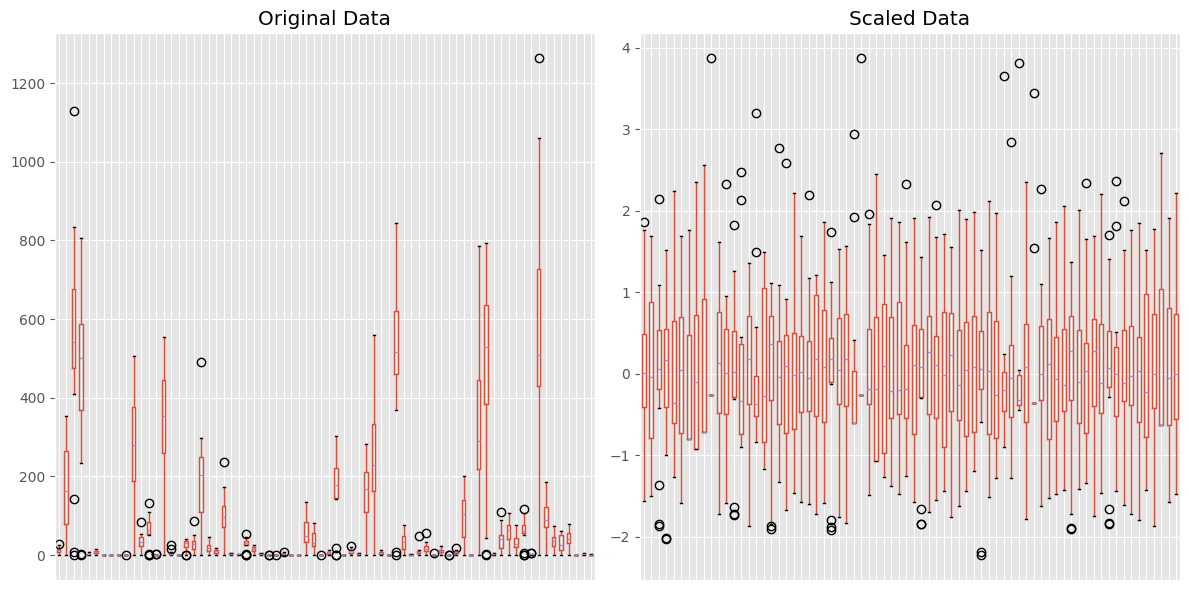

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pd.DataFrame(CLT_pivot_normalized , columns=CLT_pivot_normalized .columns).boxplot(ax=axes[0])
axes[0].set_title('Original Data')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom =False)

pd.DataFrame(CLT_standard_norm, columns=CLT_standard_norm.columns).boxplot(ax=axes[1])
axes[1].set_title('Scaled Data')
axes[1].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom =False)
#plt.xticks(visible=False)  #hides the x-labels only works wit single chart
plt.tight_layout()
plt.show()

One method of visualizing relationships is through correlation heat map.   Crimes such as bribery, disorderly conduct, and hacking contain a lot of darker colors.  This indicates slightly negative association which means as one crime increase the other crime decreases.

**Talk more about relationships**


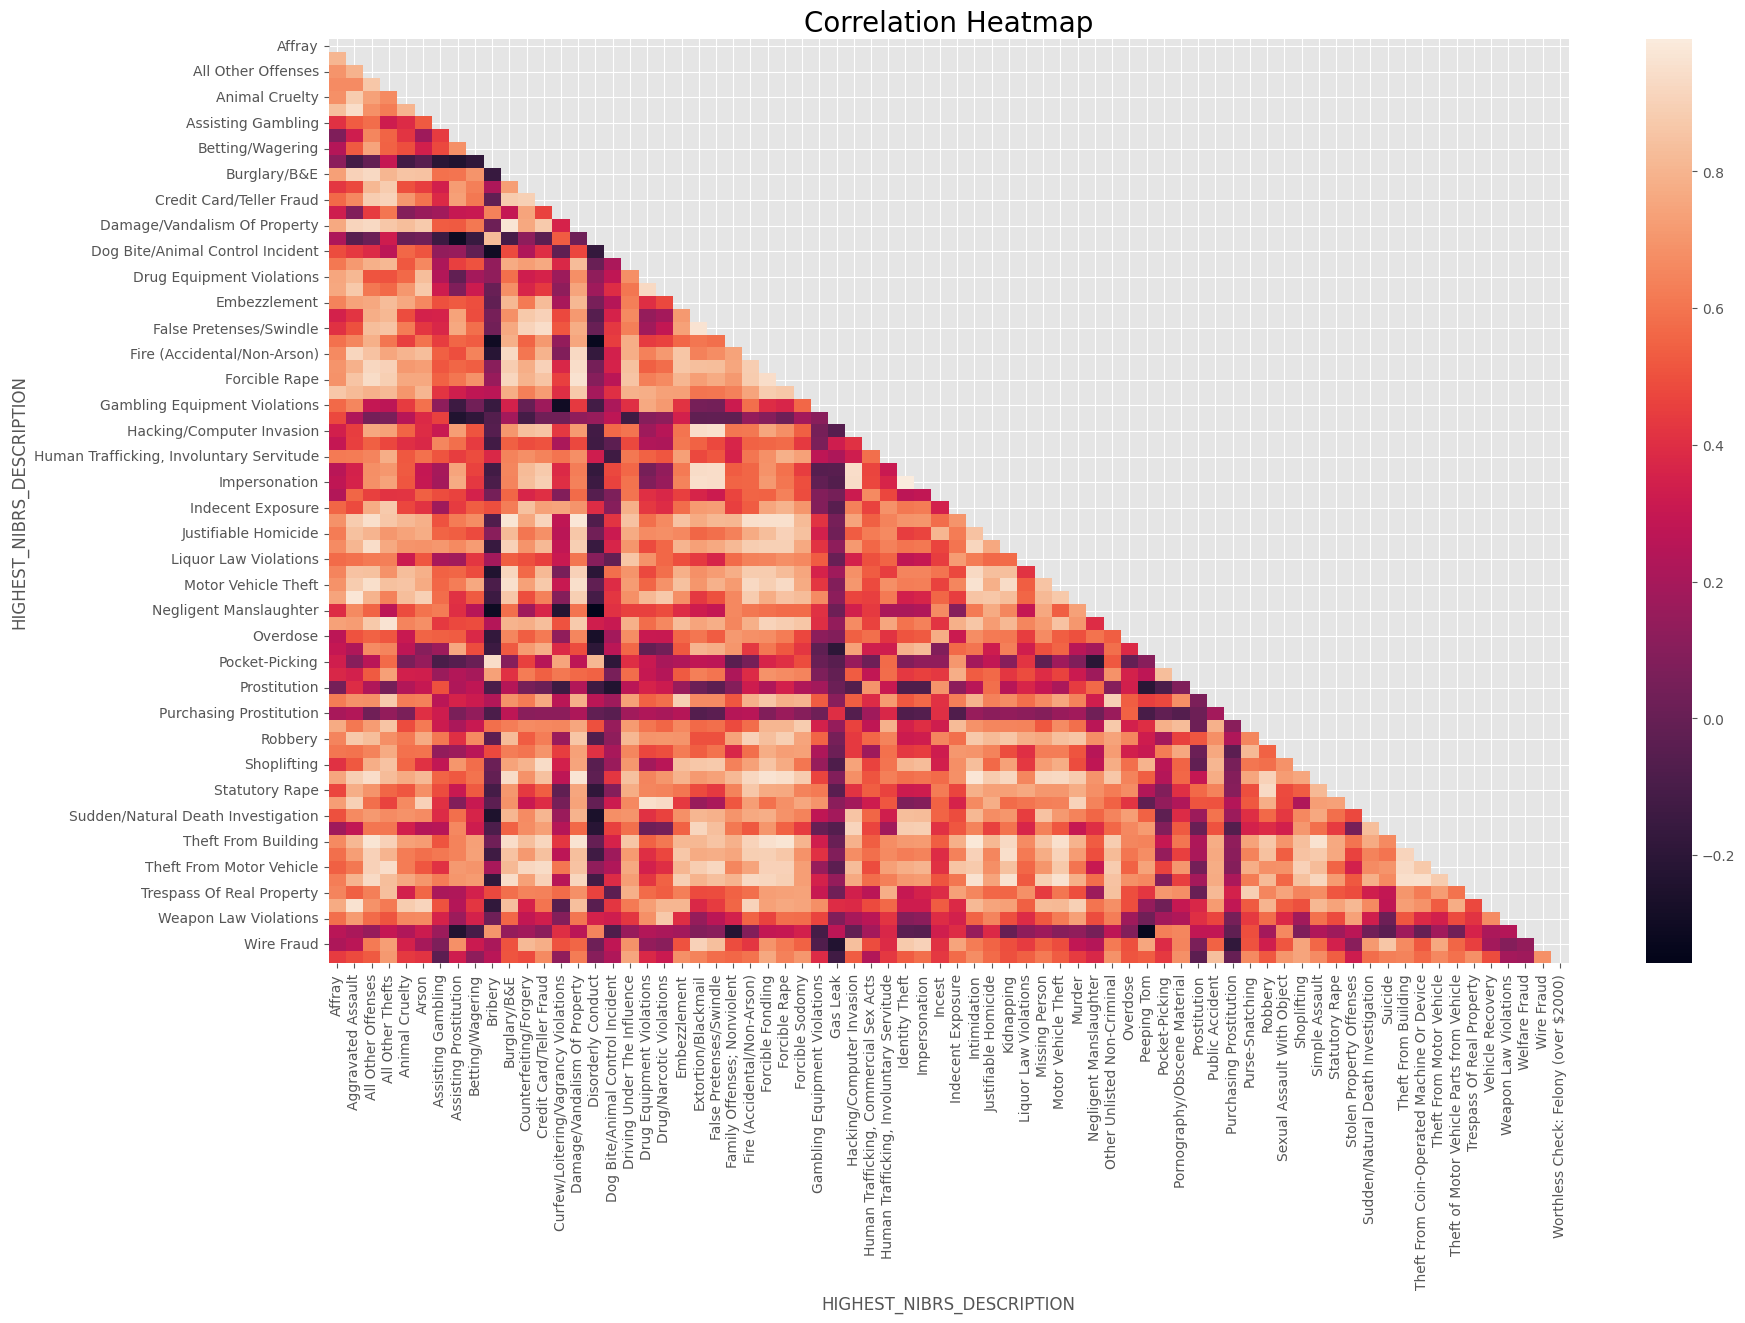

In [ ]:
# Get the correlations

corr = CLT_pivot.corr()

# Create a mask so that way we only see the lower half of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 12))

sns.heatmap(corr, mask=mask)

plt.title('Correlation Heatmap', fontsize=20)
plt.show()

In [ ]:
street_map = '/content/sample_data/Zipcode.shp'
map_df = gpd.read_file(street_map)
map_df_copy = gpd.read_file(street_map)
#map_df.head()



<Axes: >

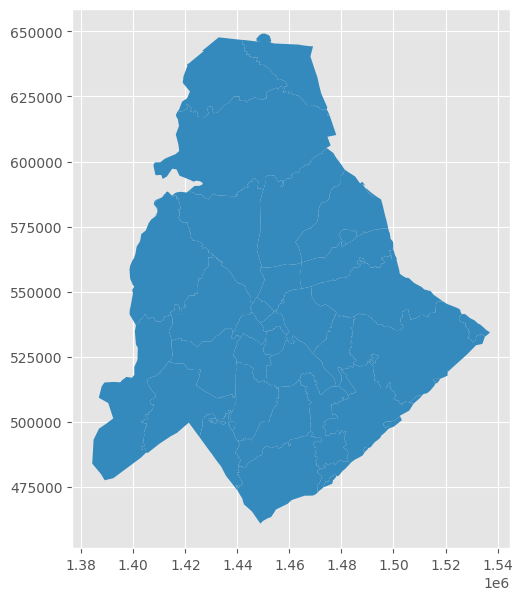

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
map_df.plot(ax=ax)

### **Modeling (Clustering)**

`What model(s) do you use to try to solve your problem? Why do you choose those model(s)?`

`For example, why choose k-means over agglomerative, or vice versa? Or perhaps experiment with both and discuss the pros/cons of each? You may also try experimenting with other methods of clustering not discussed in class.`

For this project, we experimented with k-means and agglomerative.  Both algorithms require the data to be standardized. Also, PCA will be used to reduce the number of features in the data set while retaining the most important relationships.

k-means

Pros
<ul type ="circle">
 <li>k-means is easier to use and understand in comparision to Agglomerative Hierarchical Clustering</li>
 <li>another con</li>
</ul>

Cons
<ul type ="circle">
 <li>comment1</li>
 <li>another con</li>
</ul>


Agglomerative Hierarchical Clustering

Pros
<ul type ="circle">
 <li>comment1</li>
 <li>another con</li>
</ul>

Cons
<ul type ="circle">
 <li>comment1</li>
 <li>another con</li>
</ul>

#### **Principal Componenet Analysis (PCA)**

PCA will be used to reduce the number of features in the data set while retaining the most important relationships. It reduced to just 3 combinations of features.



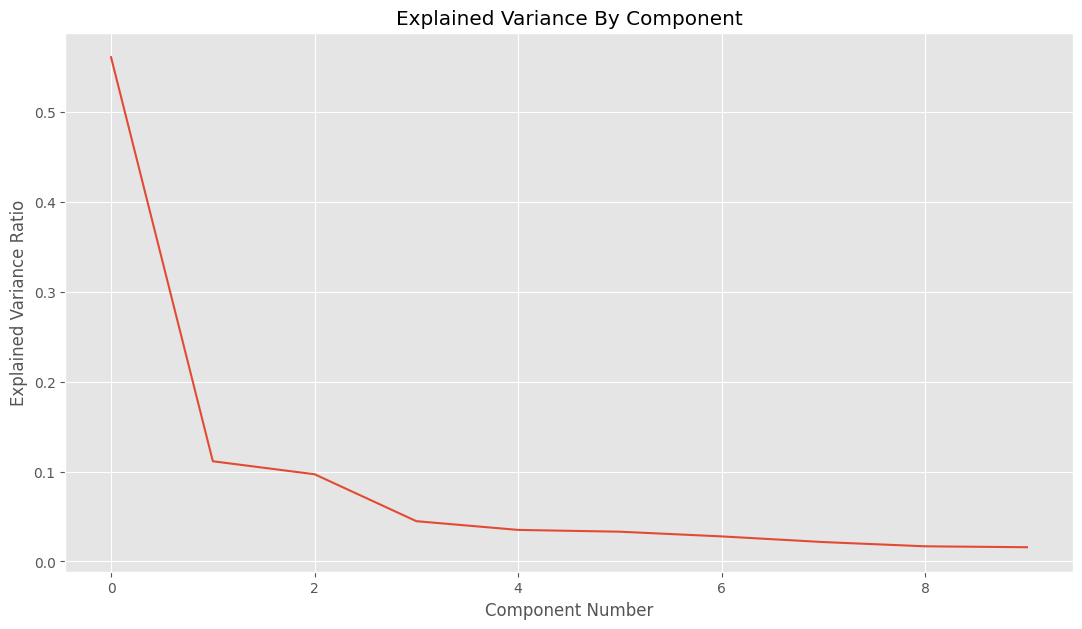

In [ ]:
# documentation: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(n_components=0.95) # instead of us picking the number, let it pick
pca.fit(CLT_standard_norm)

# Get percentage of variance explained by each of the selected components
plt.plot(pca.explained_variance_ratio_)

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance By Component')
#plt.figure(figsize=(4,4))
plt.show()

In [ ]:
# Initialize PCA at the 3 components we want
pca = PCA(n_components = 3, random_state = 42)

# Fit PCA to the data, transform the data and then make it a dataframe we know and love
pca_df = pd.DataFrame(pca.fit_transform(CLT_standard_norm))

pca_df.shape

(16, 3)

### **k-means**

The process for k-means begins with deciding on the number of clusters for our data set.  There are 16 districts (or neighborhoods) in our data.  They are now labeled 0 - 15.

Rather than guessing on the number of clusters, the elbow method is used.  This method plots the variance based on the number of clusters.  The bend in the elbow is selected as the optimal number of clusters. It represents where adding more clusters does not change the sum squared distance. Based on the elbow chart below, the best number of clusters is subjective is 3, 4 or 5.

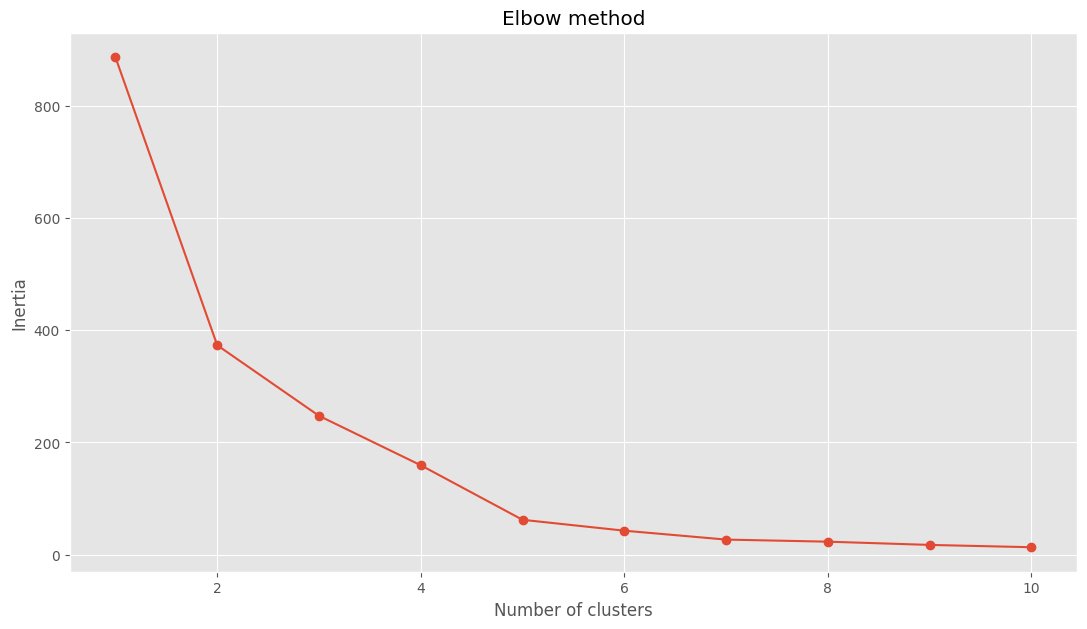

<Figure size 800x500 with 0 Axes>

In [ ]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=21)
    clusters = kmeans.fit_predict(pca_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.figure(figsize=(8,5))
plt.show()

Another method for determining the number of clusters is silhouette.  This method looks at how similar points are within the same cluster and how different points are in different clusters.  The score provides a range between 1 and -1 where 1 is the best.

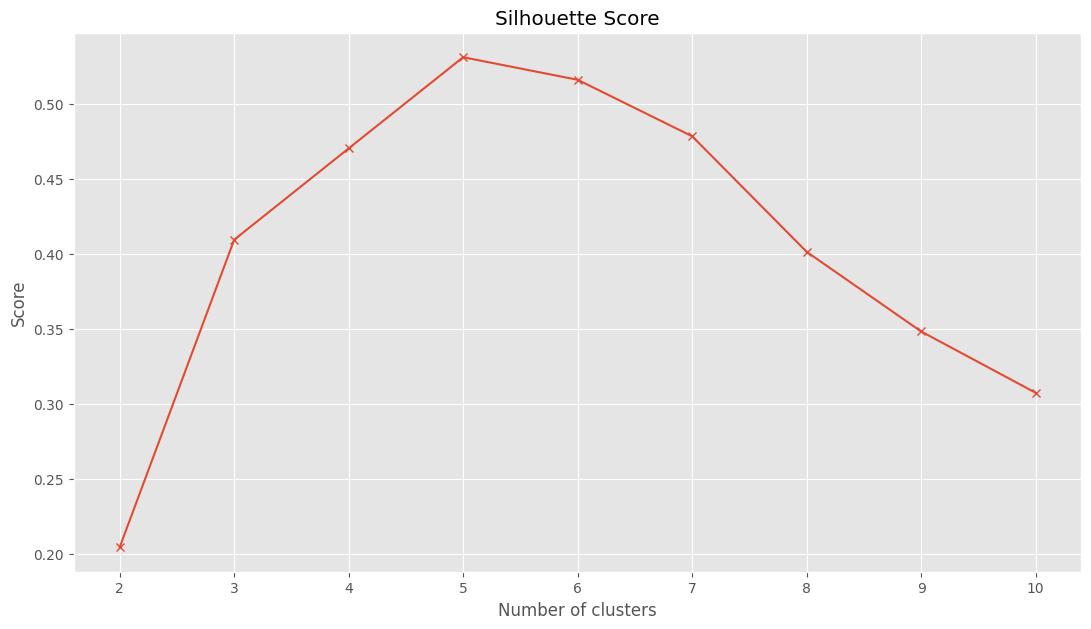

In [ ]:
silhouette_scores = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, clusters))

plt.plot(range(2,11), silhouette_scores, marker='x')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

##### **k-means - 3 clusters**

In [ ]:
# Create the model using three clusters
kmeans = KMeans(n_clusters=3, random_state=21)

# Fit the model
kmeans.fit(pca_df)

# get what cluster the model thinks the points belong to and add it to our original dataframe
CLT_standard_norm["Clusters"] = kmeans.predict(pca_df)

In [ ]:
CLT_standard_norm['Clusters'].value_counts()

Clusters
1    7
2    6
0    3
Name: count, dtype: int64

In [ ]:
'''
names_mapping = {

'Name':['Airport', 'Central','Eastway','Davidson' 'Freedom','Hickory Grove', 'Huntersville','Independence','Metro',
        'North', 'North Tryon','Providence','South','Steele Creek','University City','Westover'],
  'Clusters':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]
}

names_df = pd.DataFrame(names_mapping)
CLT_standard_norm2 = pd.DataFrame(CLT_standard_norm)

merged_df = pd.merge(names_df, CLT_standard_norm2, on='Clusters')

merged_df.set_index('Clusters', inplace=True)

merged_df
'''


"\nnames_mapping = {\n\n'Name':['Airport', 'Central','Eastway','Davidson' 'Freedom','Hickory Grove', 'Huntersville','Independence','Metro',\n        'North', 'North Tryon','Providence','South','Steele Creek','University City','Westover'],\n  'Clusters':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]\n}\n\nnames_df = pd.DataFrame(names_mapping)\nCLT_standard_norm2 = pd.DataFrame(CLT_standard_norm)\n\nmerged_df = pd.merge(names_df, CLT_standard_norm2, on='Clusters')\n\nmerged_df.set_index('Clusters', inplace=True)\n\nmerged_df\n"

In [ ]:
CLT_standard_norm['Clusters']

0     0
1     2
2     0
3     2
4     1
5     2
6     0
7     2
8     1
9     1
10    1
11    2
12    2
13    1
14    1
15    1
Name: Clusters, dtype: int32

In [ ]:
CLT_standard_norm['Clusters']= kmeans.labels_
#print(CLT_standard_norm)
CLT_standard_norm['Clusters']

0     0
1     2
2     0
3     2
4     1
5     2
6     0
7     2
8     1
9     1
10    1
11    2
12    2
13    1
14    1
15    1
Name: Clusters, dtype: int32

##### **k-means - 4 clusters**

In [ ]:
# Create the model using three clusters
kmeans = KMeans(n_clusters=4, random_state=21)

# Fit the model
kmeans.fit(pca_df)

# get what cluster the model thinks the points belong to and add it to our original dataframe
CLT_standard_norm["Clusters"] = kmeans.predict(pca_df)

In [ ]:
CLT_standard_norm['Clusters'].value_counts()

Clusters
2    6
1    4
0    3
3    3
Name: count, dtype: int64

In [ ]:
CLT_standard_norm2['Clusters']= kmeans.labels_
#print(CLT_standard_norm)  https://www.statology.org/k-means-clustering-in-python/
CLT_standard_norm2['Clusters']


0     0
1     2
2     0
3     2
4     1
5     2
6     0
7     2
8     1
9     3
10    1
11    2
12    2
13    3
14    3
15    1
Name: Clusters, dtype: int32

### **Agglomerative Hierarchical Clustering**

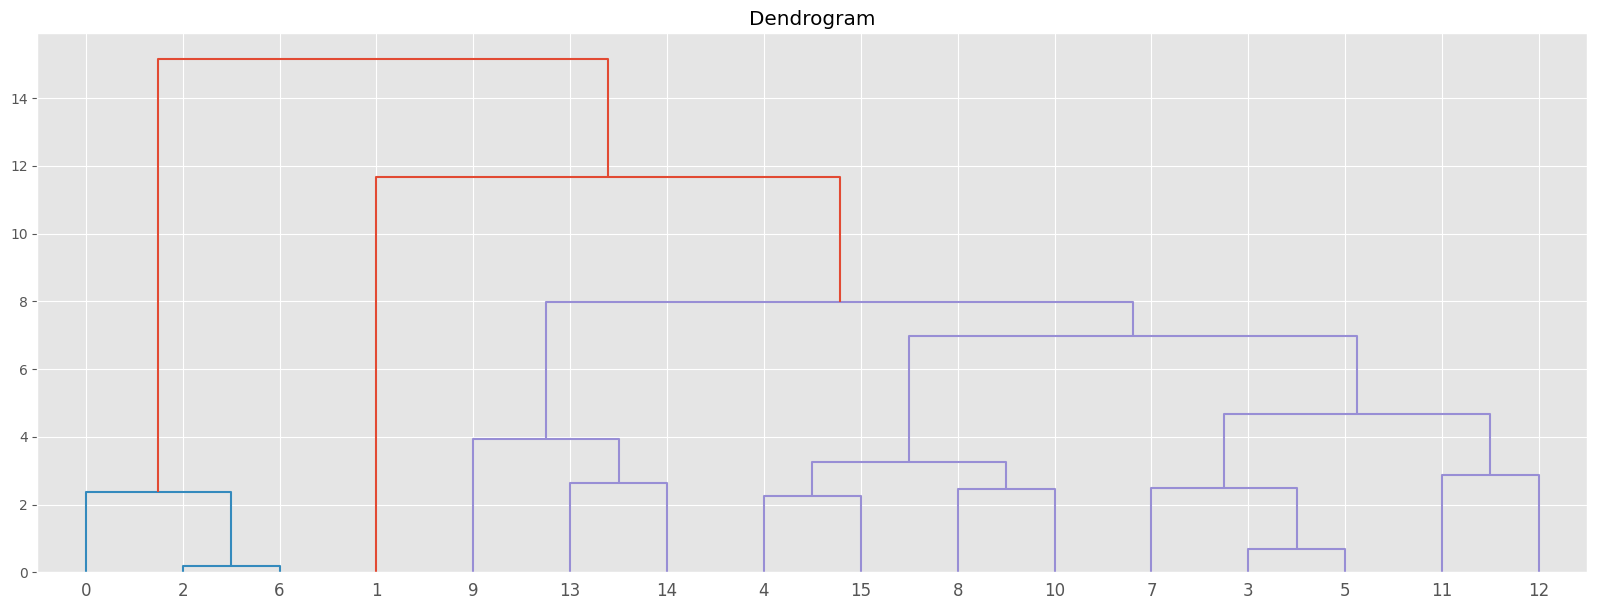

In [ ]:
# documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

plt.figure(figsize=(20, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(pca_df, method='average'),truncate_mode='level',p =10)
plt.show()

In [ ]:
'''
Agglomerate hierarchical clustering with Ward’s linkage is a technique used to automatically group data points into clusters based
on their similarities. It takes a “bottom-up” approach, starting with each data point in its own cluster and then repeatedly merging
the two closest clusters until a single cluster remains.

'''
# play around with other linkages and see how it effects how many samples are put into clusters. 'single' is a fun one
agglo = AgglomerativeClustering(linkage = 'ward')
CLT_standard_norm2['Clusters'] = agglo.fit_predict(pca_df)

In [ ]:
CLT_standard_norm2['Clusters'].value_counts()

Clusters
0    13
1     3
Name: count, dtype: int64

In [ ]:
CLT_standard_norm2['Clusters']= agglo.labels_
#print(CLT_standard_norm)
CLT_standard_norm2['Clusters']

0     1
1     0
2     1
3     0
4     0
5     0
6     1
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
Name: Clusters, dtype: int64

## **Storytelling (Clustering Analysis)**

Use this section to further analyze your clusters.

What information or insights does it tell you? What have you learned? Were you able to answer your initial problems/questions (if so, discuss that)?

In [ ]:
CLT_pivot2 = pd.pivot_table(CLT_group, values='Count',
                          columns='HIGHEST_NIBRS_DESCRIPTION', aggfunc='sum', fill_value=0)
CLT_pivot2 = CLT_pivot2.loc[:, CLT_pivot2.gt(10000).any()]
CLT_pivot2

HIGHEST_NIBRS_DESCRIPTION  Aggravated Assault  All Other Offenses  \
Count                                   21340               67235   

HIGHEST_NIBRS_DESCRIPTION  All Other Thefts  Burglary/B&E  \
Count                                 59085         33465   

HIGHEST_NIBRS_DESCRIPTION  Damage/Vandalism Of Property  \
Count                                             41165   

HIGHEST_NIBRS_DESCRIPTION  Drug/Narcotic Violations  False Pretenses/Swindle  \
Count                                         24666                    12820   

HIGHEST_NIBRS_DESCRIPTION  Intimidation  Missing Person  Motor Vehicle Theft  \
Count                             21781           19069                32063   

HIGHEST_NIBRS_DESCRIPTION  Other Unlisted Non-Criminal  Robbery  Shoplifting  \
Count                                            64275    12330        41099   

HIGHEST_NIBRS_DESCRIPTION  Simple Assault  Theft From Motor Vehicle  \
Count                               59034                     69654   

HIGHEST_NIBRS_DESCRIPTION  Theft of Motor Vehicle Parts from Vehicle  
Count                                                          11708

K-Means

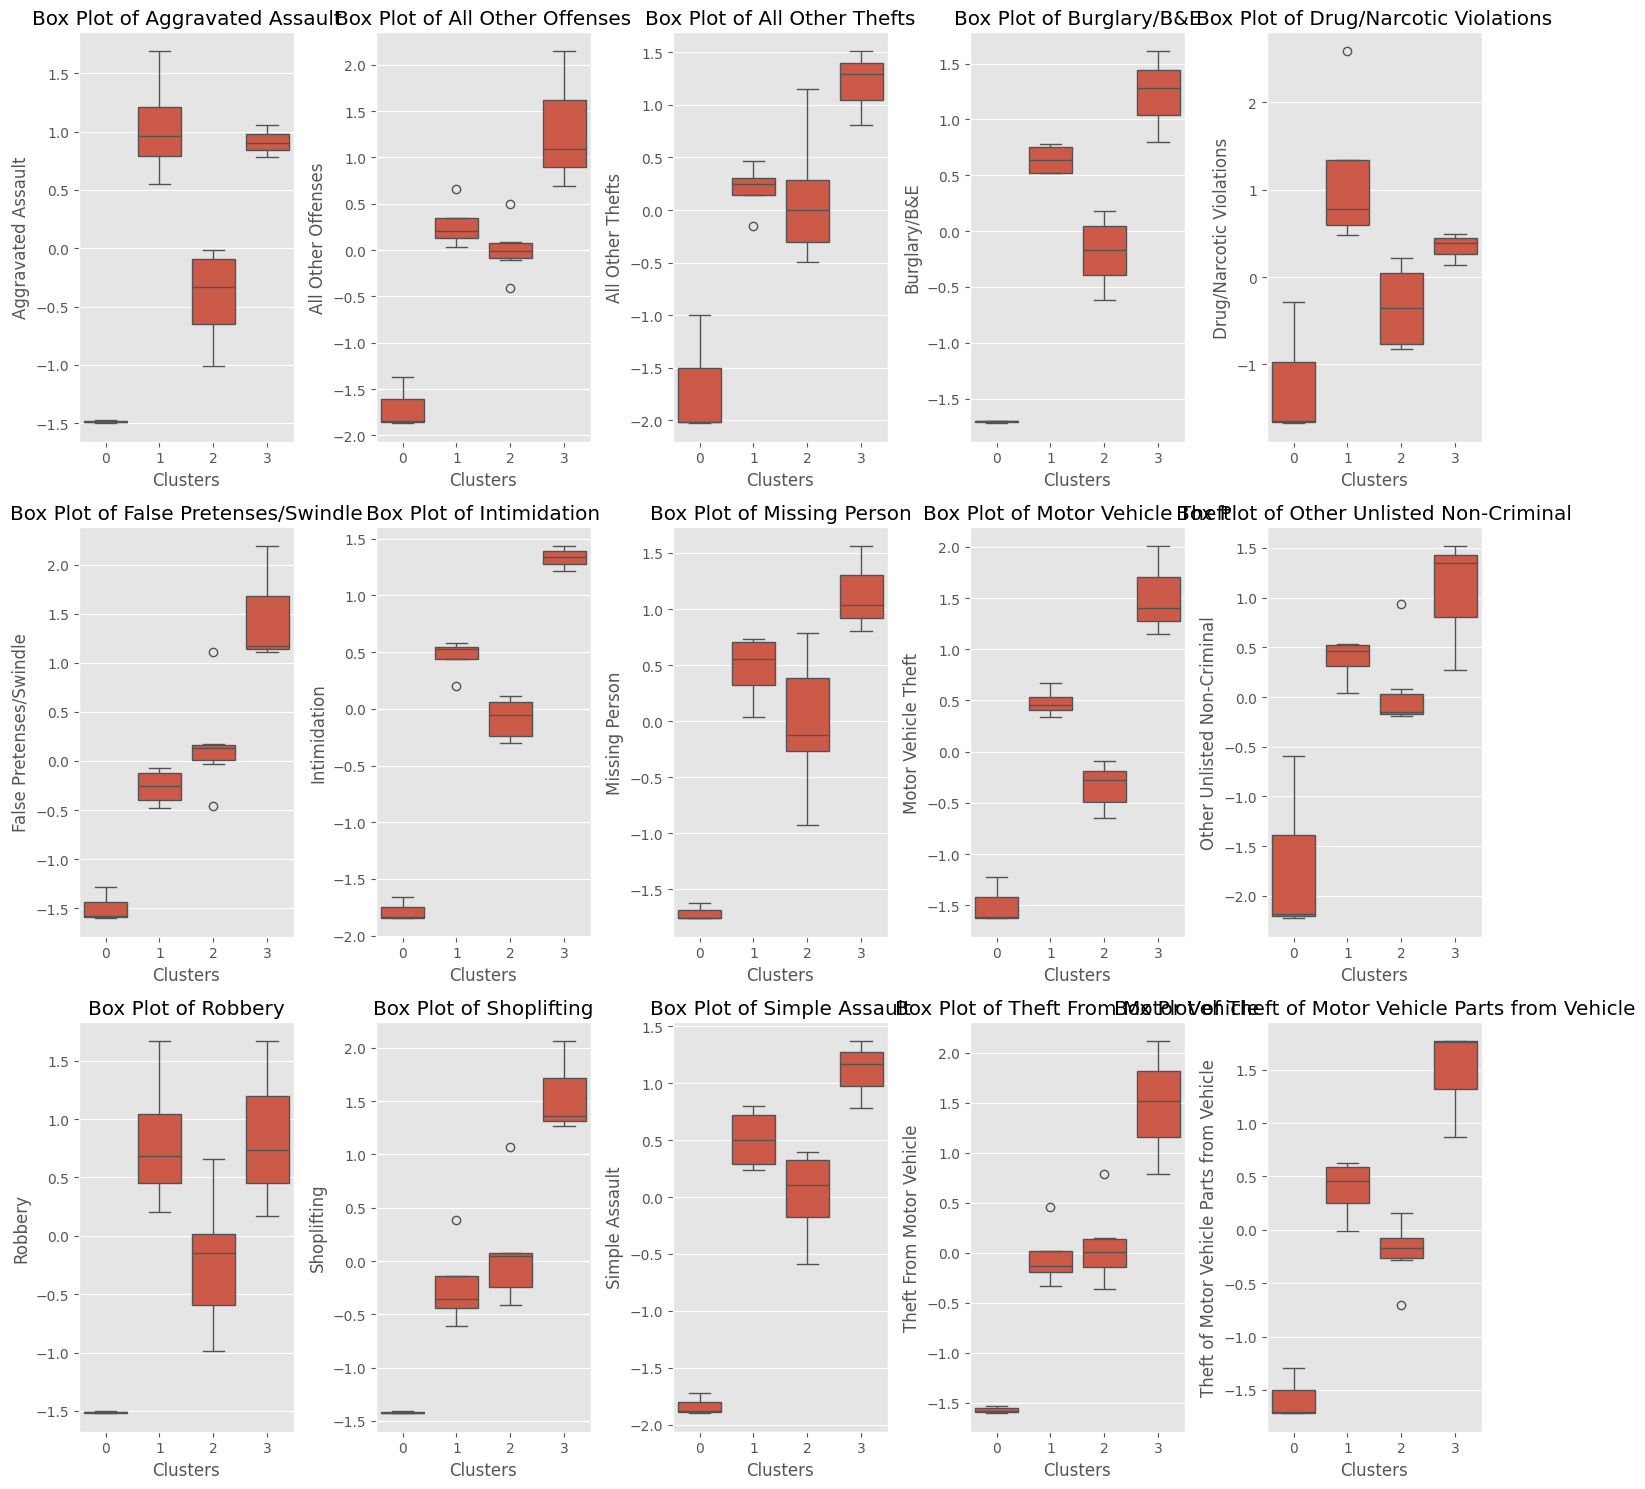

In [ ]:
subset = ['Aggravated Assault', 'All Other Offenses', 'All Other Thefts', 'Burglary/B&E','Drug/Narcotic Violations','False Pretenses/Swindle','Intimidation',
          'Missing Person', 'Motor Vehicle Theft', 'Other Unlisted Non-Criminal', 'Robbery', 'Shoplifting','Simple Assault','Theft From Motor Vehicle',
          'Theft of Motor Vehicle Parts from Vehicle']
fig, axs = plt.subplots(3, 5, figsize=(15, 15))

axs = axs.flatten() # need this so you can index axs as a 1D array rather than a multidimensional array

i = 0

for column in subset:
    sns.boxplot(data=CLT_standard_norm, y=column, x=CLT_standard_norm["Clusters"], ax = axs[i])
    axs[i].set_title(f'Box Plot of {column}')
    axs[i].set_xlabel('Clusters')
    axs[i].set_ylabel(column)

    i = i + 1

plt.tight_layout()
plt.show()

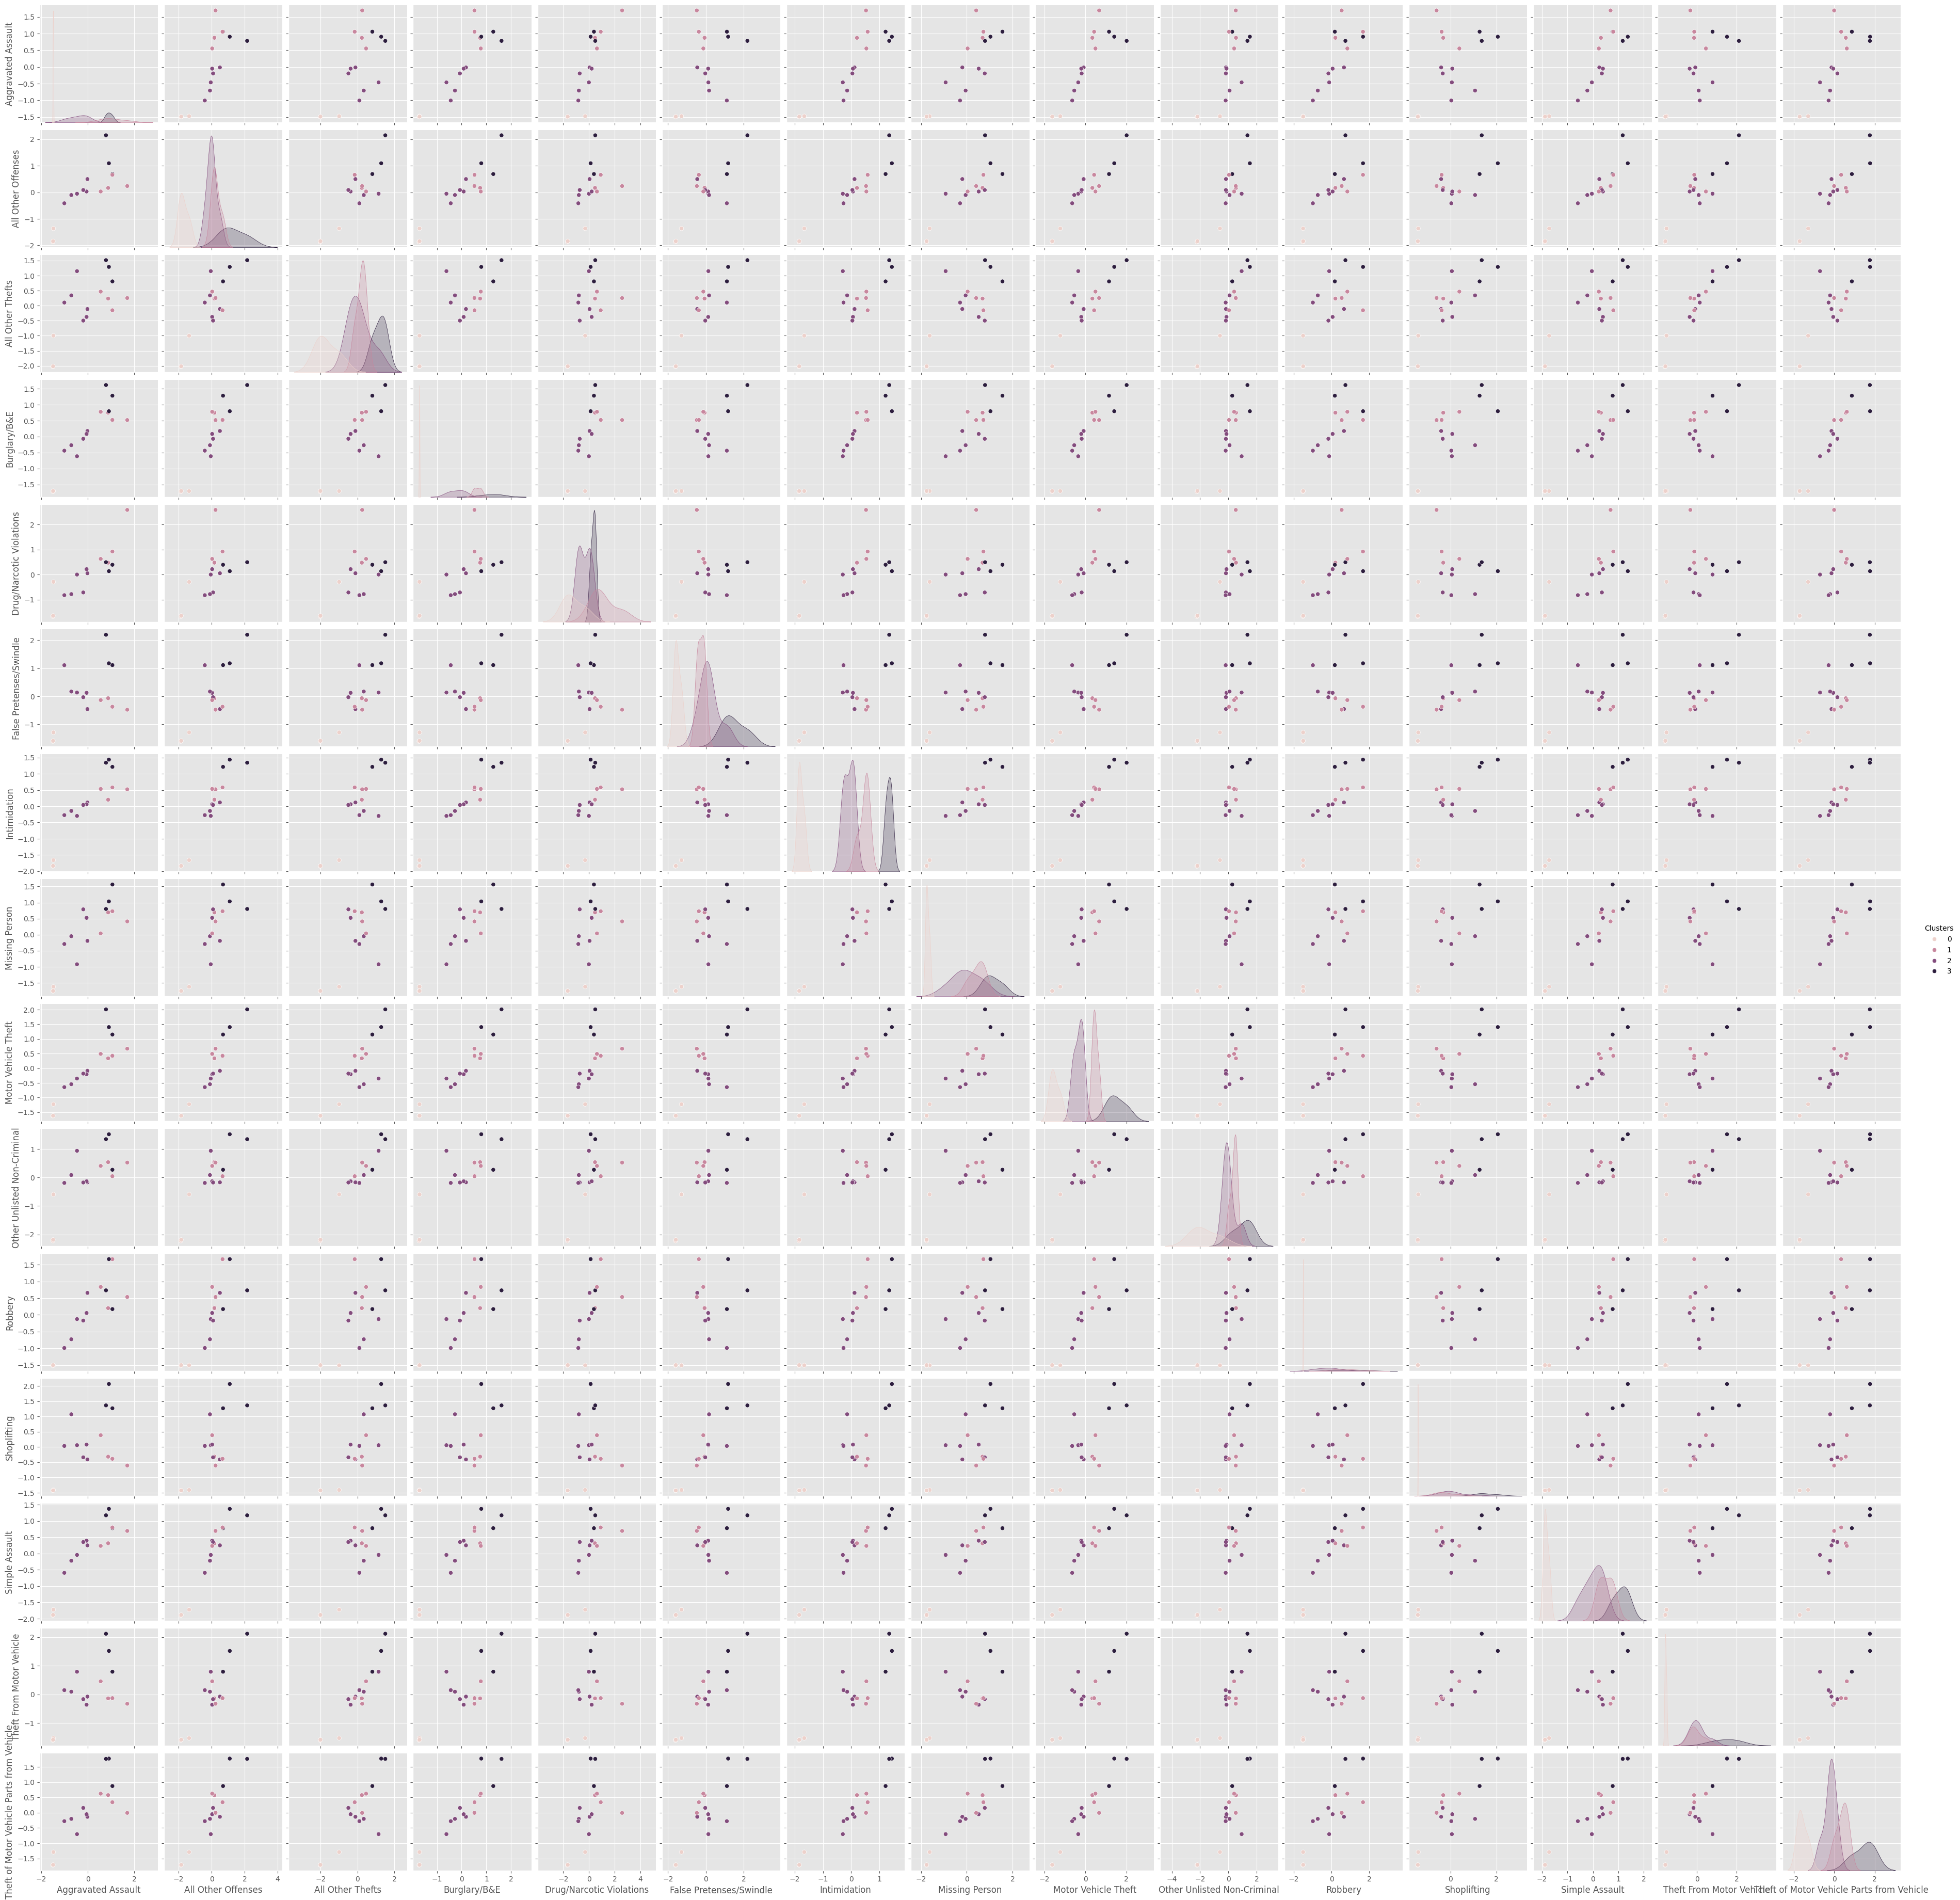

In [ ]:
sns.pairplot(CLT_standard_norm, hue='Clusters', vars=subset)
plt.show()

Agglomerative Clustering

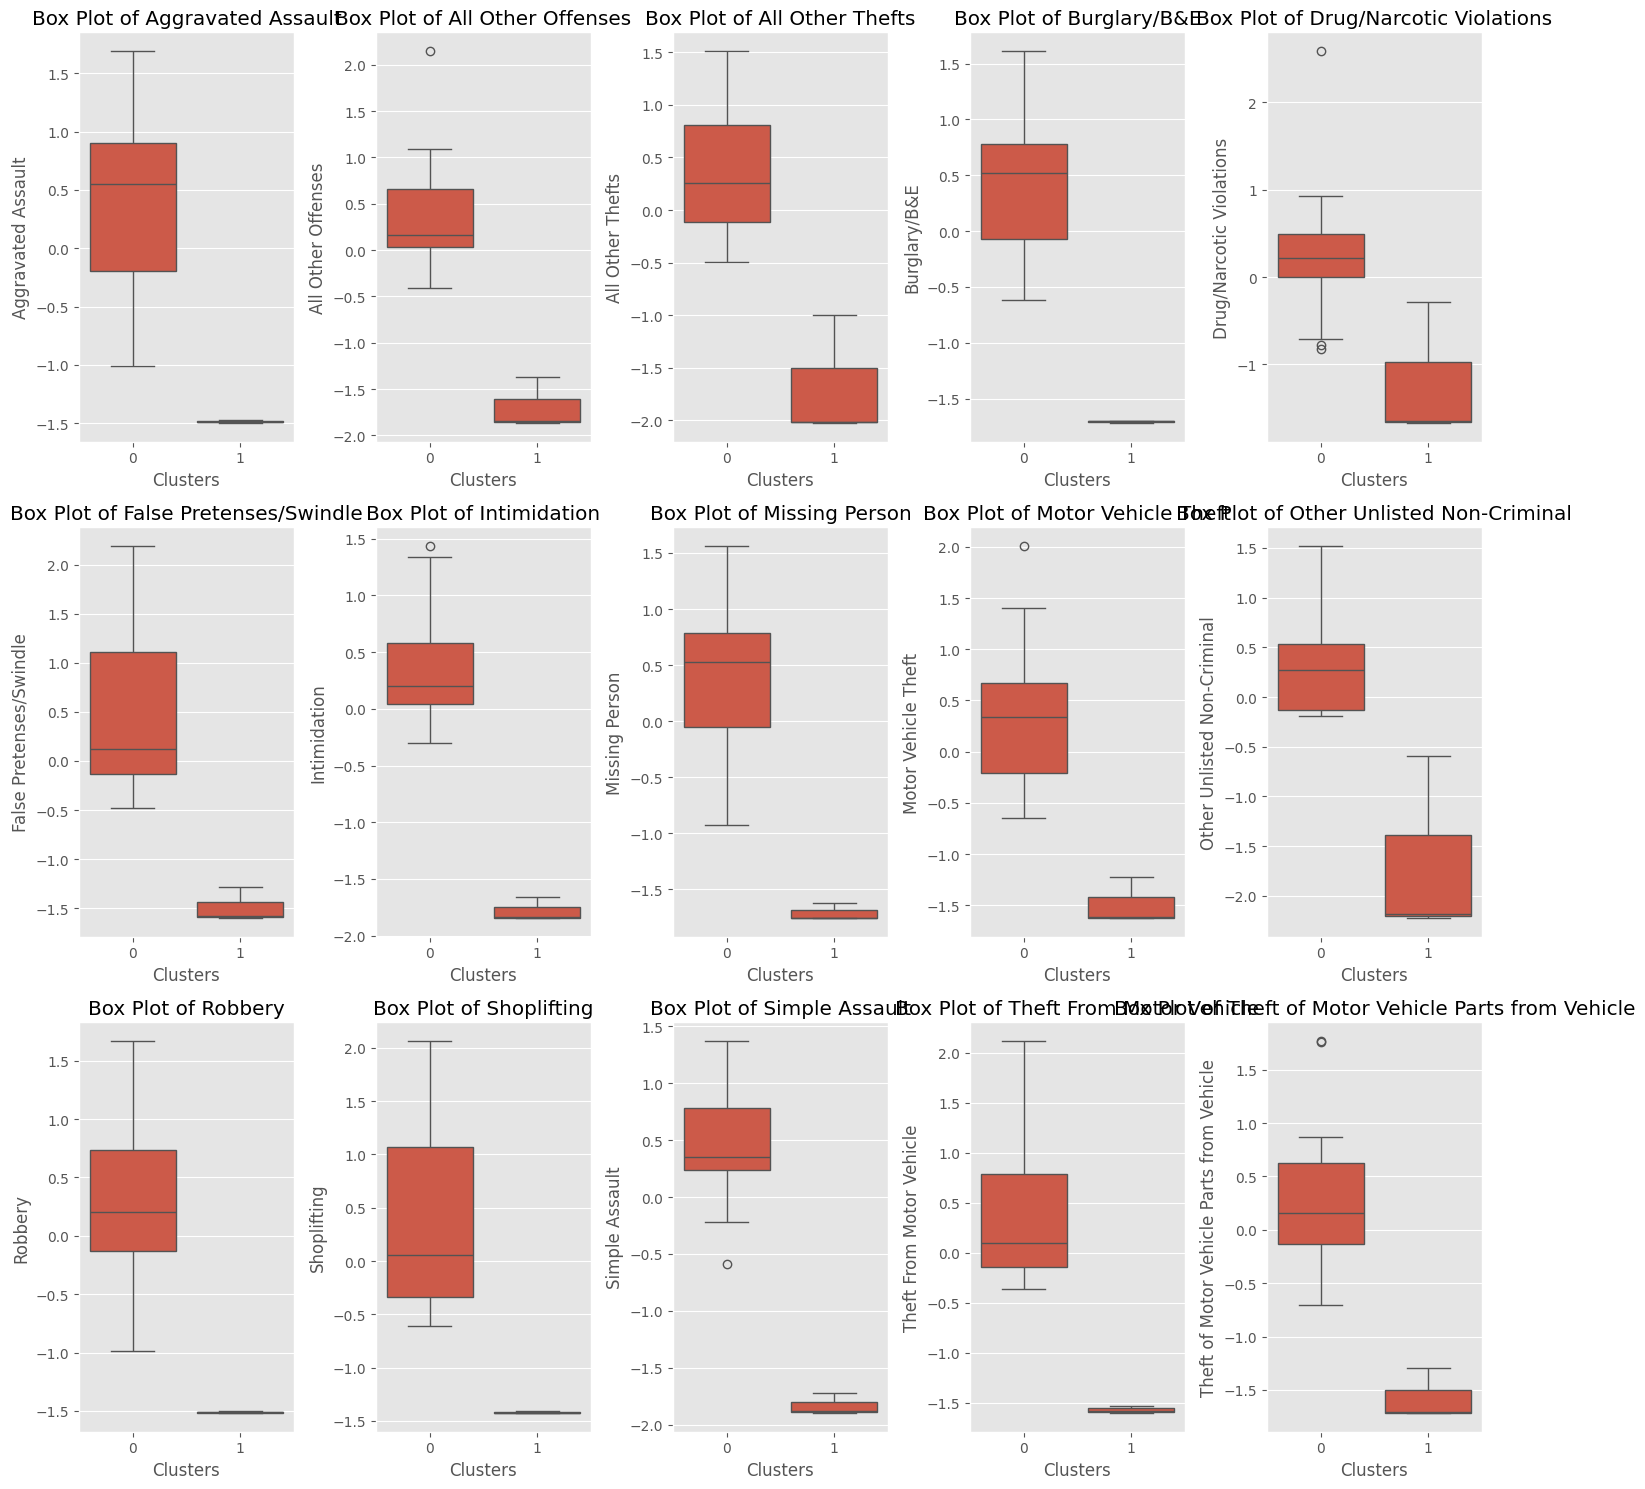

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 15))

axs = axs.flatten() # need this so you can index axs as a 1D array rather than a multidimensional array

i = 0

for column in subset:
    sns.boxplot(data=CLT_standard_norm2, y=column, x=CLT_standard_norm2["Clusters"], ax = axs[i])
    axs[i].set_title(f'Box Plot of {column}')
    axs[i].set_xlabel('Clusters')
    axs[i].set_ylabel(column)

    i = i + 1

plt.tight_layout()
plt.show()

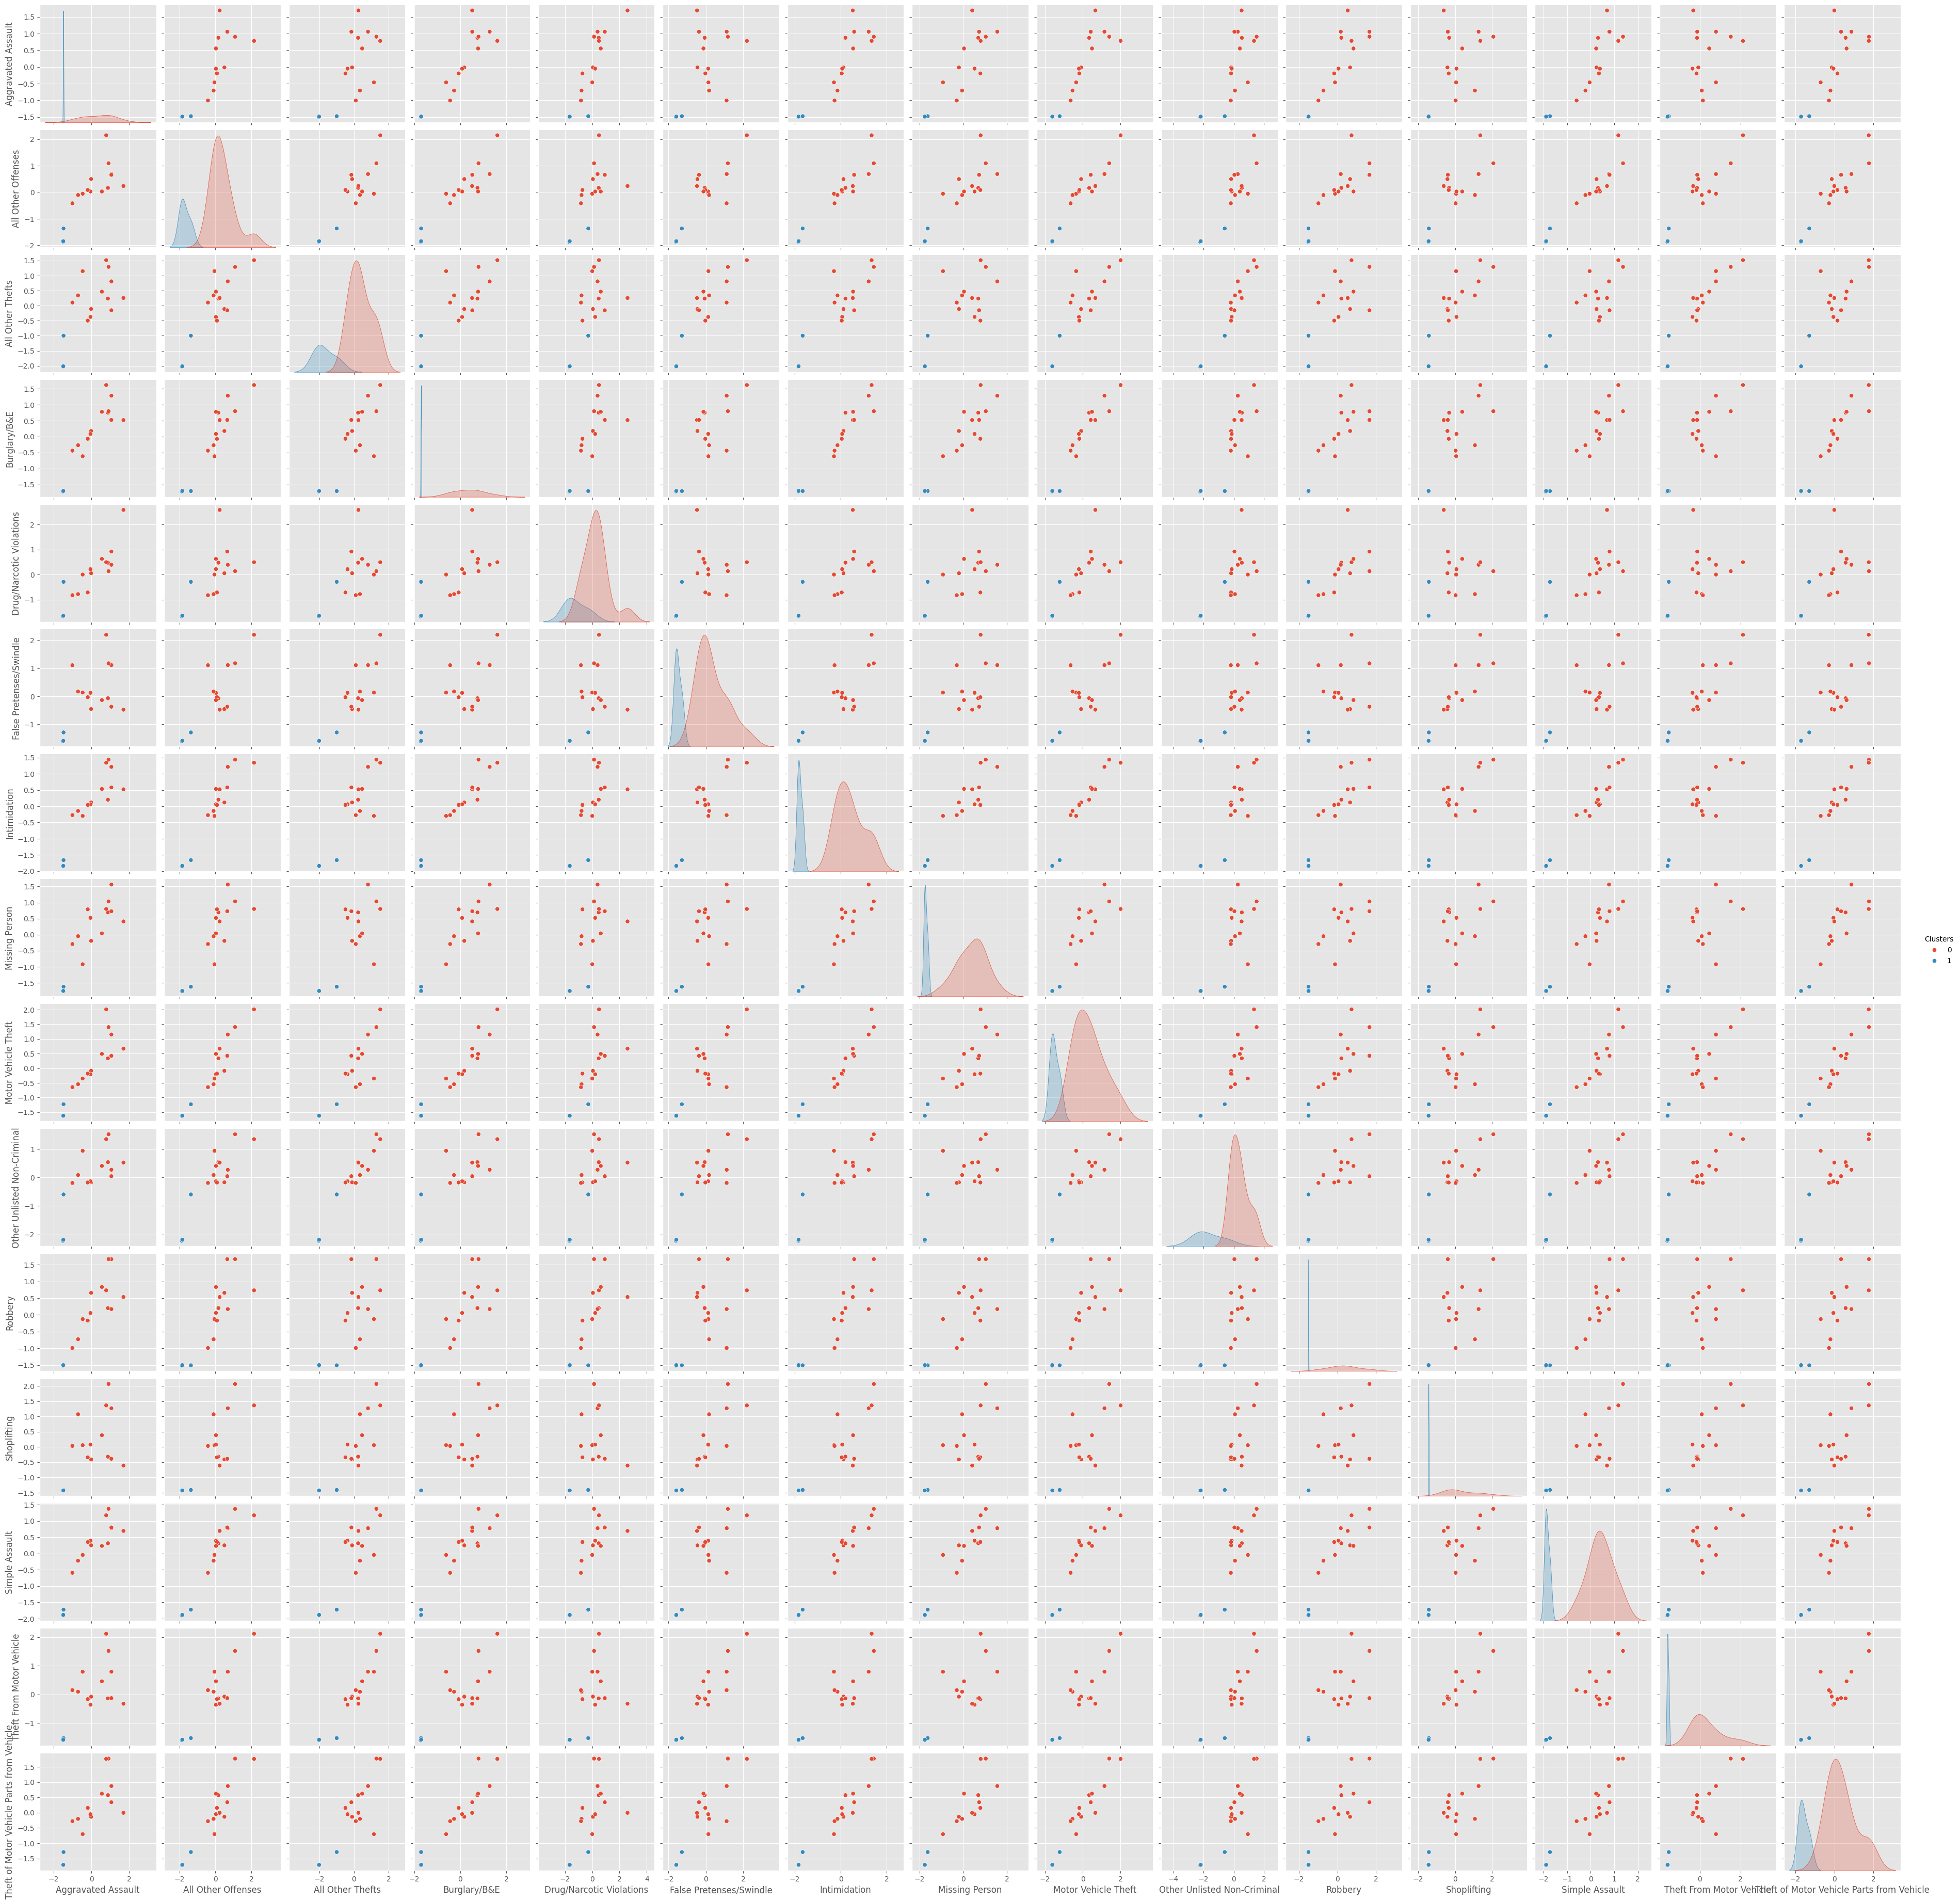

In [ ]:
sns.pairplot(CLT_standard_norm2, hue='Clusters', vars=subset)
plt.show()

## **Evaluation**

##  **Impact**



Discuss the possible impact of your project. This can be socially, ethically, etc. It cannot be something like "our project has no impact" or "our project has no negative impact." Even the most well-intentioned projects *could* have a negative impact. We will not be checking for "right" or "wrong" answers, but showing your critical thinking.


#References:
##### 1 - 6 used during Project 1
1.   https://www.charlottenc.gov/cmpd/News-Information/Crime-Statistics-Report
2.   https://data.charlottenc.gov/datasets/charlotte::cmpd-incidents-1/about
3.   https://ui.charlotte.edu/story/how-find-information-your-neighborhood
4.   https://www.charlottenc.gov/cmpd/ePolicing-Resources/Patrol-Area-Divisions
5.   https://www.wired.com/story/crime-prediction-racist-history/
6.   https://www.pbs.org/newshour/nation/why-shootings-and-violence-increase-in-the-summer-months
7.   CoPilot - how to embed HTML file into gthub
8. https://maps.mecknc.gov/openmapping/data.html
9. https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

10. https://medium.com/@shankhanilborthakur/plotting-data-visualisation-on-the-map-of-india-using-geopandas-in-python-211bc88c1e4d
11. CompletedCluseringDemo.ipynb
12. https://www.statology.org/k-means-clustering-in-python/





